In [4]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    

In [5]:
import sympy as sym
from sympy import factorial
from sympy.series.series import series

def setup_matern(p,eps = 1e-8):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)
    S = series(sym.log(matern),d,0,2*p+1).removeO()
    polyS = sym.Poly(S,d)
    asy_coeffs = polyS.coeffs()
    asy_coeffs = jnp.array(list(map(float,asy_coeffs)))

    asy_powers = polyS.monoms()
    half_asy_powers = jnp.array(asy_powers)[:,0]//2

    def matern_p_factory(rho):
        def matern_func(x,y):
            d2 = jnp.sum((x-y)**2)/(rho**2)
            d = jnp.sqrt(d2+1e-100)
            true = jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            asymptotic = jnp.exp(jnp.sum(asy_coeffs * jnp.power(d2,half_asy_powers)))
            return jnp.where(d2<eps, asymptotic, true)
        return matern_func
    
    return matern_p_factory

In [15]:
X = jax.random.uniform(jax.random.PRNGKey(10),(500,2))
y = X[:,0]**2 + 4*(X[:,0]) + X[:,1] - X[:,0]*X[:,1]

In [17]:
from Kernels import fit_kernel_params,log1pexp,inv_log1pexp

base_kernel_family = setup_matern(3)
def param_kernel(x,y,params):
    lengthscales = log1pexp(params)
    rootD = jnp.diag(jnp.sqrt(lengthscales))
    return base_kernel_family(1.)(rootD@x,rootD@y)



fitted_params = fit_kernel_params(param_kernel,X,y,jnp.zeros(2))
ML_lengthscales = log1pexp(fitted_params)
print(1/(jnp.sqrt(ML_lengthscales)))

[1.32455791 5.62427105]


: 

In [17]:
jax.grad(k,argnums=0)(0.,0.)

Array(-0., dtype=float64, weak_type=True)

In [21]:
def f(x):
    return jnp.where(x<0,1.,jnp.sqrt(jnp.abs(x+1)))

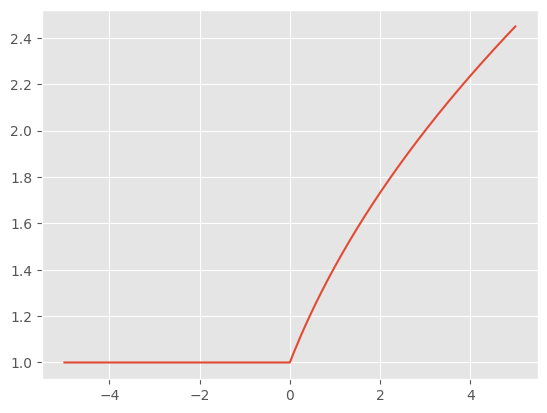

In [29]:
grid = jnp.linspace(-5,5,501)
plt.plot(grid,f(grid))

In [30]:
grid

Array([-5.  , -4.98, -4.96, -4.94, -4.92, -4.9 , -4.88, -4.86, -4.84,
       -4.82, -4.8 , -4.78, -4.76, -4.74, -4.72, -4.7 , -4.68, -4.66,
       -4.64, -4.62, -4.6 , -4.58, -4.56, -4.54, -4.52, -4.5 , -4.48,
       -4.46, -4.44, -4.42, -4.4 , -4.38, -4.36, -4.34, -4.32, -4.3 ,
       -4.28, -4.26, -4.24, -4.22, -4.2 , -4.18, -4.16, -4.14, -4.12,
       -4.1 , -4.08, -4.06, -4.04, -4.02, -4.  , -3.98, -3.96, -3.94,
       -3.92, -3.9 , -3.88, -3.86, -3.84, -3.82, -3.8 , -3.78, -3.76,
       -3.74, -3.72, -3.7 , -3.68, -3.66, -3.64, -3.62, -3.6 , -3.58,
       -3.56, -3.54, -3.52, -3.5 , -3.48, -3.46, -3.44, -3.42, -3.4 ,
       -3.38, -3.36, -3.34, -3.32, -3.3 , -3.28, -3.26, -3.24, -3.22,
       -3.2 , -3.18, -3.16, -3.14, -3.12, -3.1 , -3.08, -3.06, -3.04,
       -3.02, -3.  , -2.98, -2.96, -2.94, -2.92, -2.9 , -2.88, -2.86,
       -2.84, -2.82, -2.8 , -2.78, -2.76, -2.74, -2.72, -2.7 , -2.68,
       -2.66, -2.64, -2.62, -2.6 , -2.58, -2.56, -2.54, -2.52, -2.5 ,
       -2.48, -2.46,

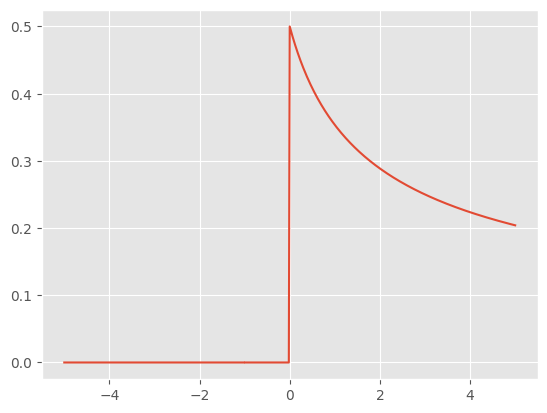

In [31]:
plt.plot(grid,jax.vmap(jax.grad(f))(grid))

In [32]:
jax.vmap(jax.grad(f))(grid)

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     